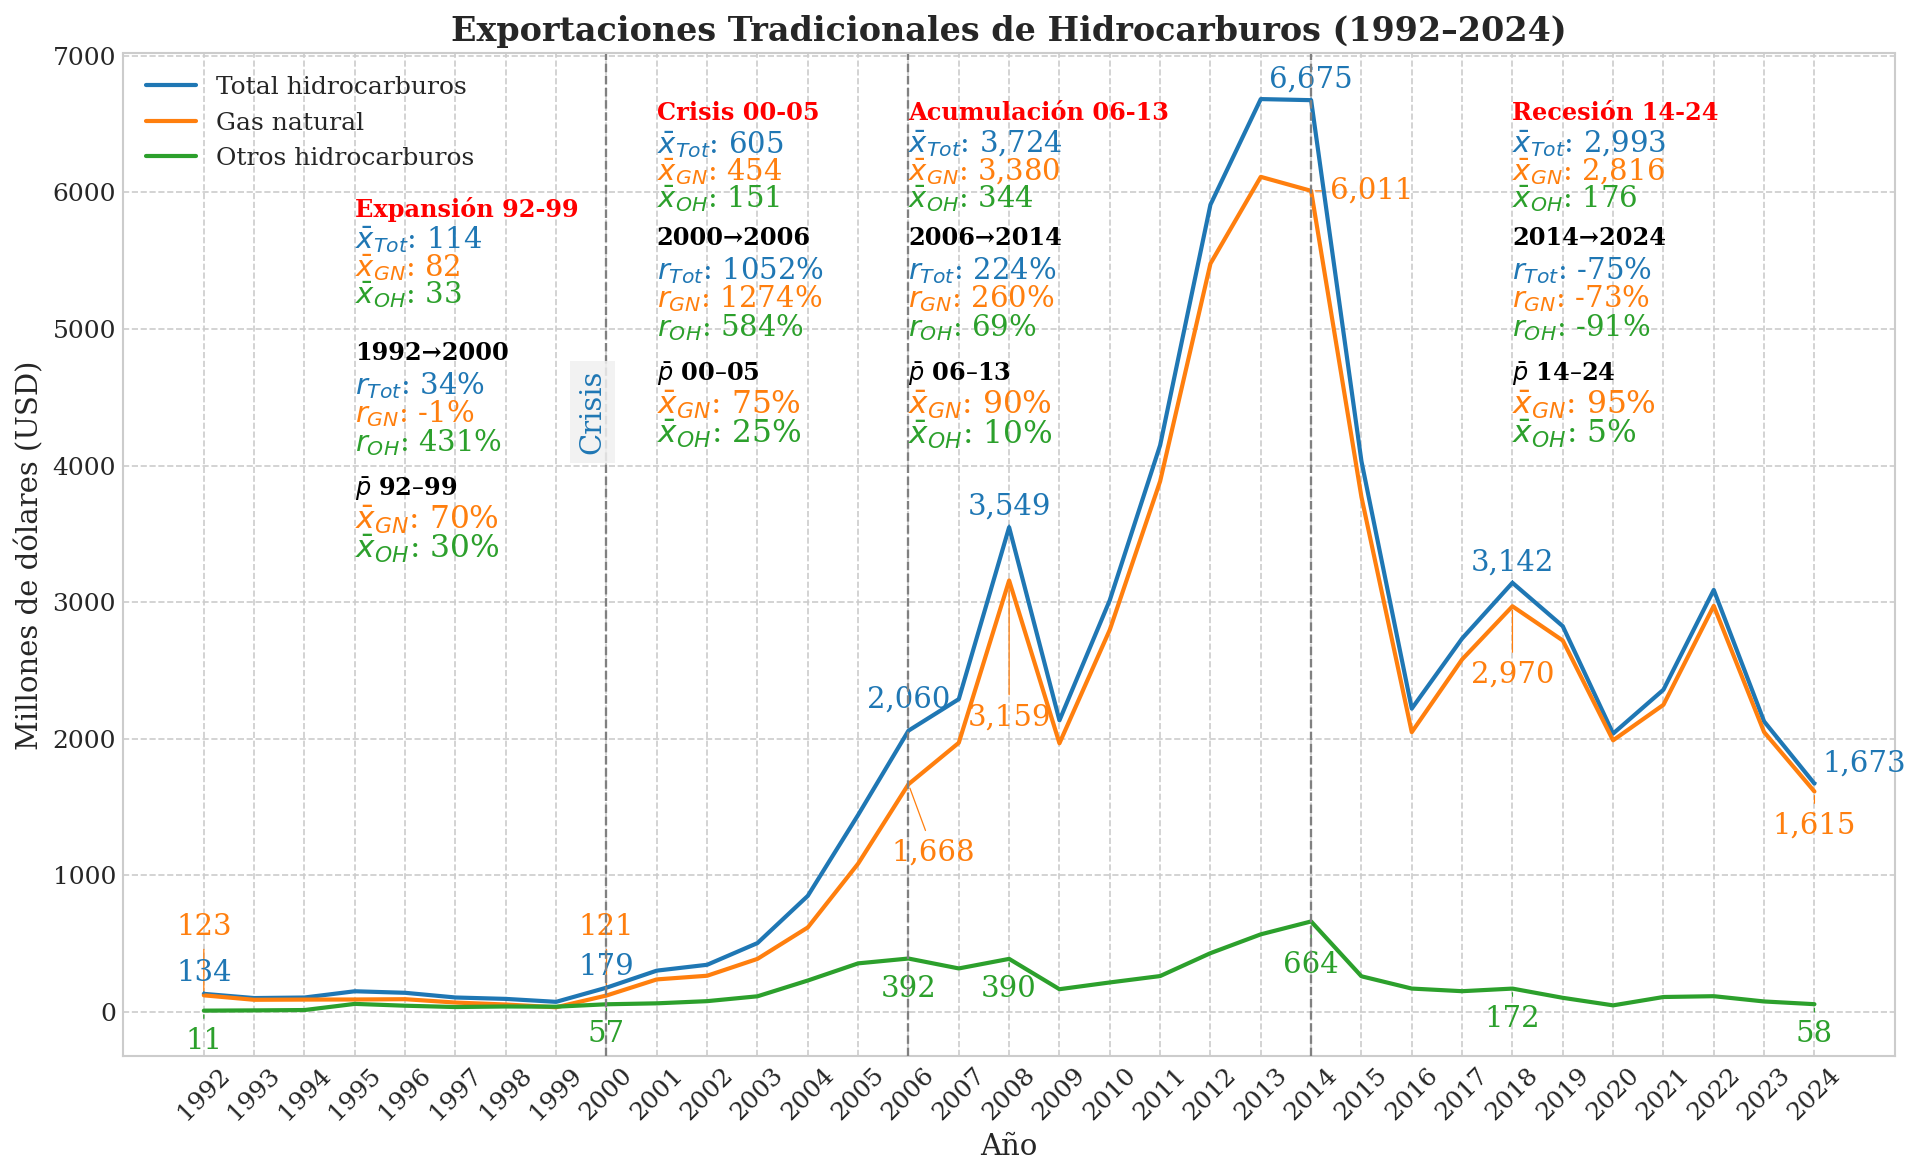

In [2]:

# ── 0. Imports ───────────────────────────────────────────────────────
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath('../'))          # ruta a graficos_utils.py
from graficos_utils import (
    add_hitos,
    add_cycle_means_multi,
    add_year_value_annotations,
    add_period_growth_annotations_multi,
    add_participation_cycle_boxes
)

# ── 1. Configuración general ─────────────────────────────────────────
OUTPUT_DIR = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family":"serif", "font.size":12,
    "axes.titlesize":16,   "axes.labelsize":14,
    "grid.linestyle":"--", "lines.linewidth":2,
    "figure.dpi":150,      "savefig.bbox":"tight",
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql(
            "SELECT * FROM exportaciones_tradicionales_hidrocarburos",
            conn, index_col="año")
          .sort_index())                 # 1992-2024, millones USD

# ── 3. Series, colores, abreviaturas ─────────────────────────────────
series = [
    ("hidrocarburos",     "Total hidrocarburos"),
    ("gas_natural",       "Gas natural"),
    ("otros_hidrocarburos","Otros hidrocarburos"),
]
cmap     = plt.get_cmap("tab10")
colors   = {col: cmap(i) for i, (col, _) in enumerate(series)}
abbr_map = {"hidrocarburos":"Tot", "gas_natural":"GN", "otros_hidrocarburos":"OH"}
cols     = [c for c,_ in series]

# ── 4. Ciclos y estadísticas ─────────────────────────────────────────
period_slices = {
    "Expansión 92-99": slice(1992, 1999),
    "Crisis 00-05": slice(2000, 2005),
    "Acumulación 06-13": slice(2006, 2013),
    "Recesión 14-24":  slice(2014, 2024),
}
cycle_stats = {name: df.loc[slc].mean().to_dict()
               for name, slc in period_slices.items()}

# Posiciones para los cuadros de medias
y_max = df[cols[0]].max()
cycle_offsets = {
    "Expansión 92-99":   (1995, 0.85),
    "Crisis 00-05": (2001, 0.95),
    "Acumulación 06-13": (2006, 0.95),
    "Recesión 14-24":    (2018, 0.95),
}

# ── 5. Hitos y anotaciones de valor ──────────────────────────────────
hitos_v = {
    2000: "Crisis",
    2006: "Expansión",
    2014: "Recesión"
}
hitos_offset = {a:0.67 for a in hitos_v}

anot_years = [1992, 2000, 2006, 2008, 2014, 2018, 2024]
annotation_offsets = {
    "hidrocarburos": {
        1992:(0,150), 2000:(0,150), 2006:(0,230),
        2008:(0,150), 2014:(0,150), 2018:(0,150), 2024:(1,150),
    },
    "gas_natural": {
        1992:(0,500), 2000:(0,500), 2006:(.5,-500),
        2008:(0,-1000), 2014:(1.2,0), 2018:(0,-500), 2024:(0,-250),
    },
    "otros_hidrocarburos": {
        1992:(0,-220), 2000:(0,-220), 2006:(0,-220),
        2008:(0,-220), 2014:(0,-320), 2018:(0,-220), 2024:(0,-220),
    },
}

# ── 6. Periodos de crecimiento (%) ───────────────────────────────────
growth_periods = [(1992,2000), (2000,2006), (2006,2014), (2014,2024)]
growth_offsets = {
    "1992-2000": (1995, 0.70),
    "2000-2006": (2001, 0.82),
    "2006-2014": (2006, 0.82),
    "2014-2024": (2018, 0.82),
}

# ── 7. Gráfico ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13,8))

for i,(col,label) in enumerate(series):
    ax.plot(df.index, df[col], label=label, color=colors[col])

# 7.1 Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offset)

# 7.2 Medias de ciclo
add_cycle_means_multi(
    ax, cycle_stats, cycle_offsets,
    abbr_map, colors,
    line_spacing=y_max*0.03
)

# 7.3 Valores puntuales
add_year_value_annotations(
    ax, df, anot_years,
    cols, annotation_offsets,
    colors, arrow_lw=0.6
)

# 7.4 Tasas de crecimiento entre tramos
add_period_growth_annotations_multi(
    ax, df, growth_periods,
    cols, growth_offsets,
    colors, abbr_map
)


components = ["gas_natural", "otros_hidrocarburos"]
total_col  = "hidrocarburos"
participation_periods = [
    (1992, 1999),
    (2000, 2005),
    (2006, 2013),
    (2014, 2024),
]
participation_offsets = {
    "1992-1999": (1995, 0.56),
    "2000-2005": (2001, 0.68),
    "2006-2013": (2006, 0.68),
    "2014-2024": (2018, 0.68),
}
# 8.6 Cuadros de participación media
add_participation_cycle_boxes(
    ax, df, participation_periods,
    components, total_col,
    participation_offsets,
    abbr_map=abbr_map,
    colors={c: colors[c] for c in components}
)

# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"Exportaciones Tradicionales de Hidrocarburos ({df.index[0]}–{df.index[-1]})",
             fontweight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Millones de dólares (USD)")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis="x", rotation=45)
ax.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,
            "exportaciones_tradicionales_hidrocarburos.png"),
            dpi=300)
plt.show()

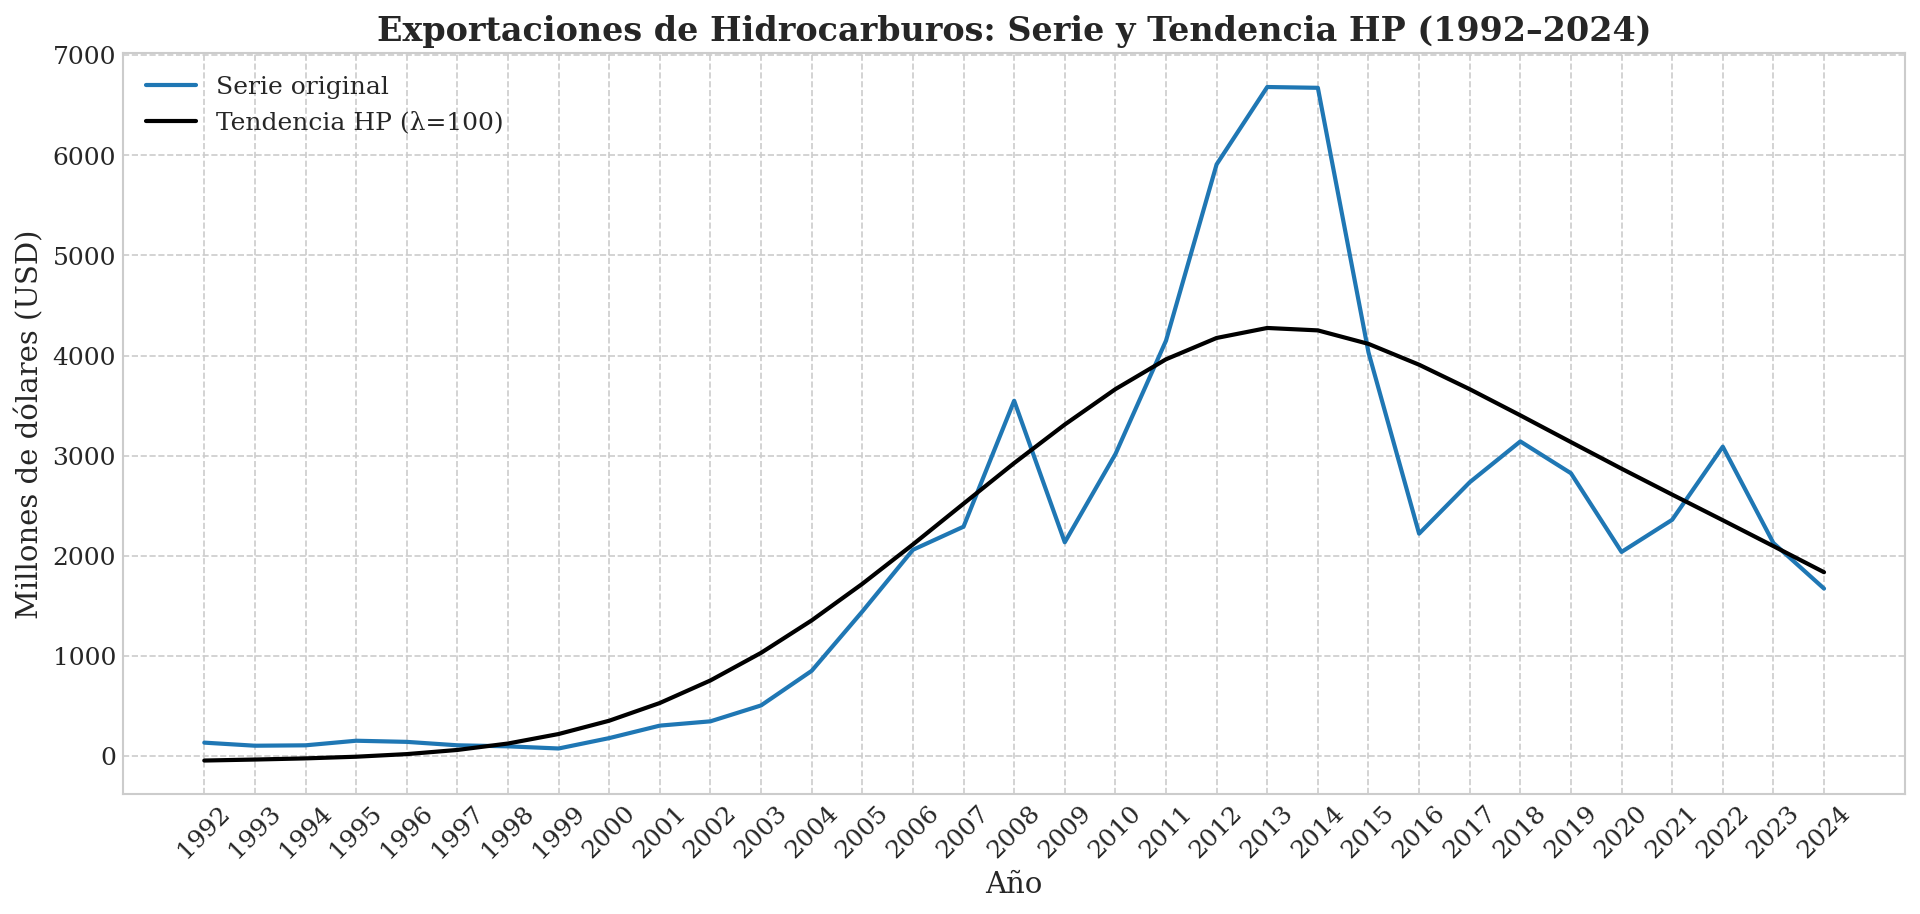

In [7]:
# ── 2.b Filtro Hodrick–Prescott ─────────────────────────────────────
from statsmodels.tsa.filters.hp_filter import hpfilter

λ_HP = 100              # anual
# Aplicamos HP al total y añadimos columnas al DataFrame
df['ciclo_hp'], df['tendencia_hp'] = hpfilter(df['hidrocarburos'], lamb=λ_HP)

# ── 2.c Visualización rápida ────────────────────────────────────────
fig_hp, ax_hp = plt.subplots(figsize=(13, 6))
ax_hp.plot(df.index, df['hidrocarburos'], color=cmap(0), label='Serie original')
ax_hp.plot(df.index, df['tendencia_hp'], color='black', linewidth=2,
           label='Tendencia HP (λ=100)')

ax_hp.set_title("Exportaciones de Hidrocarburos: Serie y Tendencia HP (1992–2024)",
                fontweight='bold')
ax_hp.set_xlabel("Año")
ax_hp.set_ylabel("Millones de dólares (USD)")
ax_hp.legend(loc='upper left')
plt.tight_layout()
ax_hp.set_xticks(df.index[::max(1,len(df)//31)])
ax_hp.tick_params(axis="x", rotation=45)
plt.show()
plt.close(fig_hp)